# Распознавание разнообразных блюд

 1. Подготовка окружения. Устанавливаю необходимые библиотеки.

In [ ]:
!pip install ultralytics albumentations matplotlib opencv-python
!pip install Pillow==9.5.0 pillow-heif==0.13.0 roboflow==1.1.0

from roboflow import Roboflow
import albumentations as A
from ultralytics import YOLO
import torch

Found existing installation: pillow-heif 0.13.0
Uninstalling pillow-heif-0.13.0:
  Successfully uninstalled pillow-heif-0.13.0
Found existing installation: roboflow 1.1.0
Uninstalling roboflow-1.1.0:
  Successfully uninstalled roboflow-1.1.0
  Using cached pillow_heif-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached roboflow-1.1.0-py3-none-any.whl.metadata (7.6 kB)
Using cached pillow_heif-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.4 MB)
Using cached roboflow-1.1.0-py3-none-any.whl (57 kB)
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2. Разметка данных происходила на Roboflow. Вставлю фрагмент из библиотеки моделей, чтобы загрузить и распаковать подготовленный набор данных.

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="UnuldCH3PgV4wJsm0OOH")
project = rf.workspace("project-9yp0e").project("-8rsy8")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Распознавание-разнообразных-блюд-3 in yolov11:: 100%|██████████| 308/308 [00:00<00:00, 1040.81it/s]


 3. Аугментация данных. На Roboflow я уже использовала аугментацию: Flip: Horizontal (отображение по горизонтали), Rotation: Between -15° and +15° (поворот на случаный угол), Hue: Between -15° and +15° (устойчивость к изменению цвета).
    Таким образом было увеличино количество данных и чтобы модель лучше обобщала. Я решила добавить еще здесь аугментацию для лучшего обучения модели (изменение яркости при разном освещении, легкое размытие, мелкие сдвиги)

In [ ]:
def get_augmentations():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

4. Перед обучением необходимо определить использовать GPU, если доступна.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

5.  Обучение модели YOLOv11. Основные параметры: количество эпох, размер изображения, размер батча.

In [ ]:
model = YOLO("yolo11m.pt")

results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=device,
    name='restaurant_train',
    exist_ok=True
)

100%|██████████| 38.8M/38.8M [00:00<00:00, 51.5MB/s]


Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Распознавание-разнообразных-блюд-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=restaurant_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]

Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytic

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    542720  ultralytics.nn.modules.block.C3k2            [1024

100%|██████████| 5.35M/5.35M [00:00<00:00, 277MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1260.5±522.8 MB/s, size: 90.4 KB)


train: Scanning /content/Распознавание-разнообразных-блюд-3/train/labels... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<00:00, 2178.42it/s]

train: New cache created: /content/Распознавание-разнообразных-блюд-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1069.7±724.0 MB/s, size: 111.1 KB)


val: Scanning /content/Распознавание-разнообразных-блюд-3/valid/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 56679.78it/s]

val: New cache created: /content/Распознавание-разнообразных-блюд-3/valid/labels.cache


Plotting labels to runs/detect/restaurant_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/restaurant_train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.96G      1.979      4.254       1.55         37        640: 100%|██████████| 9/9 [00:12<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         13        150      0.907        0.1      0.176      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.22G      1.741      1.914      1.418         19        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         13        150      0.635      0.657      0.699      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.22G      1.525      1.137      1.235         36        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         13        150      0.662       0.89      0.852      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.16G      1.505      0.964      1.246         14        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         13        150      0.757      0.846      0.855      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.25G      1.348     0.8782      1.139         19        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         13        150      0.897       0.88      0.918      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.24G      1.363     0.8663       1.19         16        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         13        150      0.894      0.877      0.924      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.24G      1.321     0.8453      1.161          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         13        150      0.898      0.861      0.898      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.21G      1.299     0.8045      1.108          6        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         13        150      0.873       0.92       0.91      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.14G      1.321     0.7958      1.154         17        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         13        150      0.811      0.885      0.893      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.24G      1.281     0.7615      1.096         29        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         13        150      0.864      0.836      0.908      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.26G      1.267     0.7158      1.113         30        640: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         13        150      0.824      0.902      0.892      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.25G      1.253      0.747       1.12         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         13        150       0.87      0.895      0.927      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.17G      1.172     0.6695      1.054         33        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


                   all         13        150      0.895      0.903      0.929      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.27G       1.19     0.6715      1.097         20        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         13        150      0.887       0.91      0.933       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.28G      1.207     0.6794      1.058         37        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         13        150      0.897      0.902      0.935      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.24G       1.15     0.6936      1.075          5        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         13        150      0.899      0.912      0.923      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       8.2G      1.193      0.665      1.087         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         13        150      0.892      0.908      0.931      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.25G      1.126      0.628      1.063         22        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         13        150      0.903      0.913      0.928      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.25G      1.121     0.6086      1.077         13        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         13        150      0.901      0.903      0.925      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.28G      1.078     0.6481      1.037          3        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         13        150      0.896      0.906      0.925      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.22G      1.134     0.6359      1.066          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         13        150      0.893      0.914      0.919      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.29G      1.191     0.6191      1.056         36        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         13        150      0.879      0.903      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.25G      1.154     0.6108      1.066         29        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13        150      0.895      0.911       0.91      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.23G      1.124     0.6053      1.086         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         13        150      0.891      0.914      0.919      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.18G      1.078     0.5931      1.051         31        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13        150      0.898      0.911      0.915      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.25G      1.119     0.5798      1.022         40        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         13        150       0.89      0.919       0.92      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.28G      1.114     0.5994      1.037         52        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         13        150      0.903      0.921      0.929      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.25G      1.041     0.5562       1.03         31        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         13        150      0.864      0.921      0.929      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.17G      1.056     0.5587      1.027         19        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         13        150      0.891      0.914      0.921      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.26G      1.052     0.5345      1.077         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         13        150      0.913      0.902       0.92      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.26G      1.003     0.5414      1.026         24        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         13        150      0.923      0.914      0.925      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.26G     0.9947      0.529      1.052         12        640: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         13        150      0.899      0.916      0.934      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.19G      1.041     0.5515     0.9992         41        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         13        150      0.917      0.922      0.941      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.26G      1.082      0.595       1.07         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         13        150      0.914      0.919      0.938      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.25G       1.03     0.5352      1.037         16        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         13        150      0.888      0.916      0.947      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.27G      1.005     0.5479      1.017          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         13        150      0.913      0.911      0.946      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.13G     0.9971     0.5463     0.9916         26        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         13        150      0.913      0.919      0.943      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.21G     0.9729     0.5095      0.993         35        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         13        150      0.899      0.903       0.94      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.21G     0.9711     0.5904     0.9987          2        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         13        150        0.9      0.898      0.937      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.23G     0.9484      0.501     0.9914         25        640: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


                   all         13        150      0.915      0.918      0.941      0.601
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.29G      1.007     0.5242      1.012         16        640: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         13        150      0.921       0.92      0.943      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.35G     0.9539     0.4839      1.016         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         13        150      0.907      0.911      0.934      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.37G     0.9222     0.4622      1.016         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         13        150      0.897      0.908      0.934      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       8.4G     0.9388     0.4734      1.001         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         13        150      0.897      0.917      0.931      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.29G     0.9276     0.4619      0.998         14        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         13        150      0.909      0.913      0.937      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.39G     0.9293     0.4486      1.027         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         13        150      0.914      0.913      0.941      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.35G      0.879      0.463       0.98          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         13        150      0.913      0.908      0.941      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.35G     0.8386     0.4365     0.9738          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         13        150      0.912      0.908      0.941      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.29G     0.8662     0.4391      0.968         12        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         13        150      0.906      0.909      0.942      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.35G      0.845     0.4246     0.9736         13        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        150      0.905       0.91      0.941      0.612



50 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/restaurant_train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/restaurant_train/weights/best.pt, 40.5MB

Validating runs/detect/restaurant_train/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,041,597 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         13        150      0.913      0.911      0.946      0.623
               borscht          3          3      0.985          1      0.995      0.711
         borscht plate          2          2       0.89          1      0.995      0.747
                   cup         12         22      0.914      0.966      0.963      0.732
           greek salad          5          5      0.817          1      0.995      0.638
              jalapena         10         10      0.908          1       0.94      0.471
                  lard          3          4      0.685      0.554      0.895       0.47
                 onion         12         24      0.952      0.958      0.946      0.516
         pumpkin plate          3          3       0.89      0.667      0.699      0.559
          pumpkin soup          3          3       0.93          1      0.995      0.435
                  rids         12         13      0.823      0.769      0.905      0.538
                 sauc

6. Отследила метрики: mAP, precision, recall, F1-score

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics.utils.plotting import plot_results

def analyze_training_results(run_path='runs/detect/restaurant_train'):
    results_csv = pd.read_csv(f'{run_path}/results.csv')

    plot_results(file=f'{run_path}/results.csv', dir='')
    plt.show()

    final_metrics = {
        'mAP50': results_csv['metrics/mAP50(B)'].iloc[-1],
        'mAP50-95': results_csv['metrics/mAP50-95(B)'].iloc[-1],
        'Precision': results_csv['metrics/precision(B)'].iloc[-1],
        'Recall': results_csv['metrics/recall(B)'].iloc[-1]
    }

    precision = final_metrics['Precision']
    recall = final_metrics['Recall']
    final_metrics['F1-score'] = 2 * (precision * recall) / (precision + recall + 1e-16)

    print("\nФинальные метрики модели:")
    for k, v in final_metrics.items():
        print(f"{k}: {v:.3f}")

    return final_metrics

initial_metrics = analyze_training_results()


Финальные метрики модели:
mAP50: 0.941
mAP50-95: 0.613
Precision: 0.905
Recall: 0.910
F1-score: 0.908


7. Провела 1 итерацию оптимизации гиперпараметров, так как результаты уже с первого раза не плохие.

In [ ]:
from ultralytics import YOLO

def train_with_optimization(optimization_params, name_suffix='_opt1'):
    model = YOLO("yolo11m.pt")

    params = {
        'data': f"{dataset.location}/data.yaml",
        'epochs': 70,
        'imgsz': 640,
        'batch': 16,
        'device': device,
        'name': f'restaurant_train{name_suffix}',
        'exist_ok': True,
        **optimization_params
    }

    results = model.train(**params)
    return analyze_training_results(f'runs/detect/restaurant_train{name_suffix}')

opt1_metrics = train_with_optimization({
    'lr0': 0.01,
    'weight_decay': 0.05,
    'dropout': 0.2,
    'optimizer': 'AdamW'
}, '_opt1')

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Распознавание-разнообразных-блюд-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=restaurant_train_opt1, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=

train: Scanning /content/Распознавание-разнообразных-блюд-3/train/labels.cache... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 613.3±516.5 MB/s, size: 111.1 KB)


val: Scanning /content/Распознавание-разнообразных-блюд-3/valid/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]


Plotting labels to runs/detect/restaurant_train_opt1/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.05), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/restaurant_train_opt1
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      8.68G      2.131      3.945      1.637         37        640: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all         13        150     0.0767      0.242     0.0125    0.00463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      8.91G      2.212      3.288      1.839         19        640: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      8.91G      1.954      2.139       1.68         36        640: 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      8.85G      1.883      1.956      1.652         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      8.93G      1.791      1.694      1.587         19        640: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      8.91G       1.78      1.512      1.586         16        640: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      8.93G      1.703      1.459      1.508          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70       8.9G      1.869      1.424      1.628          6        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      8.84G      1.712       1.31      1.526         17        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      8.94G      1.705      1.248      1.461         29        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      8.96G      1.644      1.185      1.445         30        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      8.95G      1.678      1.185      1.504         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      8.85G      1.663      1.083      1.434         33        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      8.95G      1.584      1.114      1.452         20        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      8.97G      1.521      1.047      1.344         37        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         13        150          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      8.94G      1.545      1.265      1.461          5        640: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         13        150     0.0328     0.0278     0.0241    0.00651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      8.89G      1.551      1.072       1.41         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13        150      0.584      0.264      0.354      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      8.95G      1.489     0.9903      1.389         22        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         13        150      0.378      0.395      0.234      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      8.92G      1.516     0.9867      1.411         13        640: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         13        150      0.306      0.522      0.409      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      8.96G      1.533      1.083      1.451          3        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         13        150      0.601      0.724       0.73      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70       8.9G      1.485     0.9696       1.36          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         13        150      0.636      0.377      0.522       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      8.96G       1.49     0.9518       1.32         36        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         13        150      0.619      0.266      0.372      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      8.95G      1.462     0.9452      1.357         29        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         13        150      0.653      0.582      0.644      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      8.92G      1.523      1.026      1.441         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         13        150      0.513      0.305      0.462      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      8.86G      1.378     0.9077      1.328         31        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         13        150      0.169      0.398      0.346      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      8.93G      1.458     0.8844        1.3         40        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         13        150      0.724       0.79      0.834      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      8.96G      1.438      0.903      1.315         52        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         13        150      0.747       0.65      0.753      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      8.94G      1.419     0.8833      1.327         31        640: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         13        150      0.873      0.713      0.864      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      8.86G      1.406     0.8753      1.319         19        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         13        150      0.811      0.746      0.787        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      8.94G      1.361     0.8153       1.33         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         13        150      0.868      0.847      0.901      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      8.94G      1.365     0.8349      1.316         24        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         13        150      0.888      0.762      0.885      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      8.95G      1.357     0.8339      1.358         12        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         13        150       0.64      0.715      0.758       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      8.88G      1.363     0.8461       1.26         41        640: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         13        150      0.427      0.627      0.592        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      8.95G      1.403     0.8789      1.345         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         13        150      0.648      0.751      0.785      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      8.93G      1.319     0.7817      1.296         16        640: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         13        150      0.809      0.794      0.829      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      8.98G      1.361     0.8005      1.307          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         13        150      0.807      0.917      0.865      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      8.82G      1.381     0.7956      1.256         26        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         13        150      0.834      0.807      0.865      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70       8.9G      1.345     0.7851       1.28         35        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         13        150      0.774      0.756      0.842      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       8.9G      1.458      1.121       1.43          2        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        150      0.807      0.796      0.852      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      8.92G       1.33     0.7685      1.276         25        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         13        150      0.825      0.883      0.896      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      8.88G      1.309     0.7742      1.228         26        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


                   all         13        150      0.765      0.766      0.825      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      8.93G        1.3     0.7961      1.295         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         13        150      0.691       0.83      0.807      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      8.93G      1.258     0.7585      1.264          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        150      0.698      0.871      0.864      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      8.96G      1.353      0.778      1.338         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         13        150      0.836      0.885      0.903      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      8.85G      1.331     0.7836      1.296         13        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         13        150      0.836      0.905      0.927      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      8.92G      1.262     0.7269      1.219         58        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         13        150      0.812      0.897      0.921       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      8.91G      1.259     0.7015      1.245         12        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         13        150      0.846      0.902      0.912      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      8.96G      1.285     0.7726      1.288         21        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         13        150      0.877      0.897       0.91      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70       8.9G      1.286     0.7367       1.24         33        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         13        150      0.788      0.908      0.904      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      8.91G      1.264     0.7372      1.271         25        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         13        150       0.81      0.897      0.911      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      8.89G      1.345     0.7536      1.237         32        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

                   all         13        150      0.786      0.892      0.905       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      8.94G      1.224     0.6994      1.209         17        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         13        150      0.896      0.823      0.876      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      8.85G      1.308     0.7333      1.238         29        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         13        150      0.808      0.919      0.916      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      8.95G      1.225     0.7041      1.202         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         13        150      0.808      0.936      0.909      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      8.94G       1.19     0.6696      1.174         18        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13        150      0.789      0.929      0.903      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      8.91G       1.25     0.6957      1.221         23        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         13        150      0.822      0.928      0.923      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      8.86G      1.195     0.6617      1.225         21        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         13        150       0.84      0.932      0.929       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      8.88G       1.22     0.6674      1.196          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         13        150      0.847      0.938      0.924      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      8.93G       1.18     0.6777      1.233         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         13        150      0.847      0.919      0.927      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      8.98G      1.202      0.673      1.194         36        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         13        150      0.843      0.923      0.927      0.584


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      8.97G        1.2     0.7869      1.248          3        640: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         13        150      0.833      0.921      0.934      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      9.05G       1.19     0.6577      1.317         14        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         13        150      0.823      0.908      0.927      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      9.03G      1.157     0.6196      1.234         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         13        150      0.848      0.909      0.922      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      9.08G      1.121     0.6077      1.212         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         13        150      0.906      0.901      0.931      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      8.97G      1.113     0.5936      1.216          3        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         13        150      0.914      0.901      0.933      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      9.03G      1.136     0.6034      1.235         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         13        150      0.902      0.903       0.93      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      9.05G      1.161     0.5967      1.236         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         13        150       0.87      0.896      0.925      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      9.03G       1.12     0.5968      1.238         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         13        150      0.867      0.899      0.932      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      8.96G      1.121      0.596      1.201         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         13        150       0.88        0.9       0.93      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      9.07G      1.067     0.6586        1.2          3        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         13        150      0.885      0.903      0.929      0.594



70 epochs completed in 0.141 hours.
Optimizer stripped from runs/detect/restaurant_train_opt1/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/restaurant_train_opt1/weights/best.pt, 40.5MB

Validating runs/detect/restaurant_train_opt1/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,041,597 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


                   all         13        150       0.84      0.932      0.929       0.61
               borscht          3          3      0.785          1      0.995      0.669
         borscht plate          2          2      0.778          1      0.995      0.796
                   cup         12         22      0.826          1      0.958      0.757
           greek salad          5          5      0.837          1      0.995      0.664
              jalapena         10         10       0.86          1      0.986      0.516
                  lard          3          4      0.546      0.615      0.605      0.328
                 onion         12         24      0.973          1      0.995      0.515
         pumpkin plate          3          3       0.57      0.667      0.687      0.517
          pumpkin soup          3          3       0.97          1      0.995      0.384
                  rids         12         13      0.845      0.841      0.884      0.529
                 sauc

8. Сравню две модели теперь (исходную vs оптимизированную)


 Сравнение метрик:
            Initial  Optimized
mAP50      0.941260   0.928760
mAP50-95   0.612500   0.594390
Precision  0.905250   0.885190
Recall     0.909940   0.903030
F1-score   0.907589   0.894021


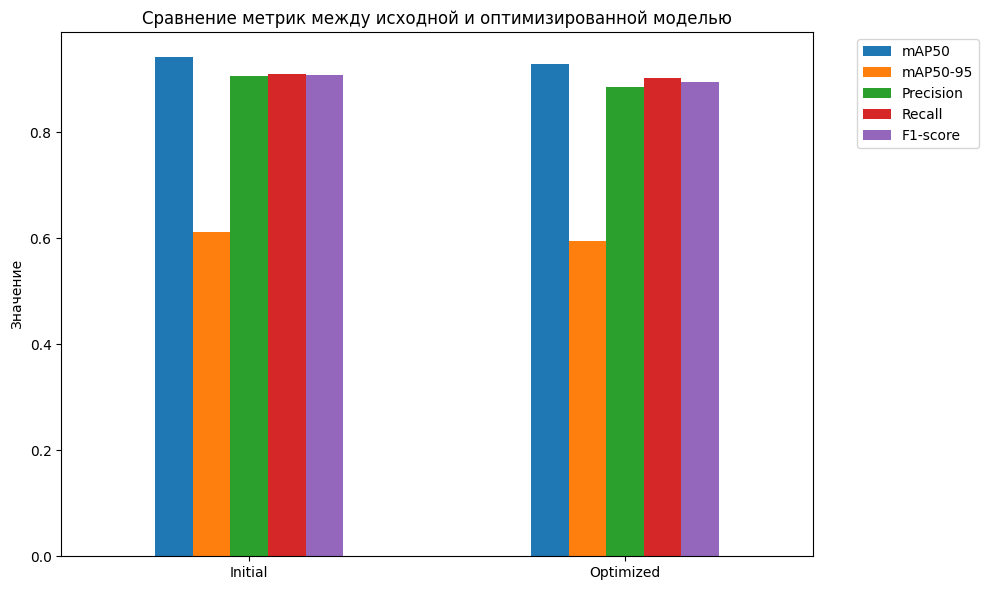

In [ ]:
def compare_results(initial, opt1):
    metrics = ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1-score']
    comparison = pd.DataFrame({
        'Initial': [initial[m] for m in metrics],
        'Optimized': [opt1[m] for m in metrics]
    }, index=metrics)

    print("\n Сравнение метрик:")
    print(comparison)

    # Графическое сравнение
    comparison.T.plot(kind='bar', figsize=(10, 6))
    plt.title('Сравнение метрик между исходной и оптимизированной моделью')
    plt.ylabel('Значение')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Пример вызова:
compare_results(initial_metrics, opt1_metrics)

Оптимизированная модель немного уступила первой модели.


9. Тестирование на одном изображении. Необходимо указать путь к тестовому изображению. И после сохраняется изображение с детекциями.


image 1/1 /content/Распознавание-разнообразных-блюд-3/train/images/-2025-06-28-16-13-22_png.rf.60eb3fb7545580e41280a79f0cd73cf8.jpg: 640x416 1 borscht, 2 cups, 1 greek salad, 1 jalapena, 1 lard, 2 onions, 1 pumpkin soup, 1 rids, 2 sauces, 1 seefood salad, 1 stuffed flatbreads, 1 tea, 27.9ms
Speed: 9.7ms preprocess, 27.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 416)


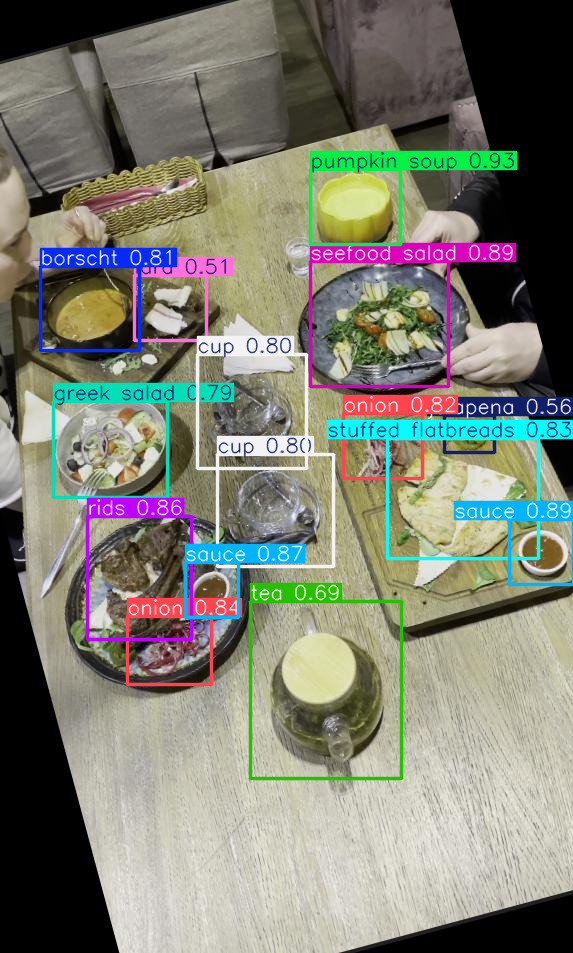

'result.jpg'

In [ ]:
test_img = "/content/Распознавание-разнообразных-блюд-3/train/images/-2025-06-28-16-13-22_png.rf.60eb3fb7545580e41280a79f0cd73cf8.jpg"

results = model(test_img)
results[0].show()

results[0].save(filename="result.jpg")

 10. Обработка видео. Позволяет обрабатывать видео покадрово, рисовать bounding boxes и сохранять результат в виде нового файла. Удобно для демонстрации работы модели.

In [ ]:
from IPython.display import Video, display
from ultralytics import YOLO
import cv2
import os
from google.colab import files

print("Загрузите видео:")
uploaded = files.upload()
video_path = next(iter(uploaded))  # Получаем имя загруженного файла
output_path = "output_video.mp4"

cap = cv2.VideoCapture(video_path)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
cap.release()

out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

results = model(video_path, stream=True)
for frame in results:
    im = frame.plot()
    out.write(im)

out.release()

display(Video(output_path, embed=True))

9. Отображение классов.

In [ ]:
import yaml

with open(f"{dataset.location}/data.yaml") as f:
    data_yaml = yaml.safe_load(f)

print("Классы:")
for idx, cls in enumerate(data_yaml['names']):
    print(f"{idx}: {cls}")

Классы:
0: borscht
1: borscht plate
2: cup
3: greek salad
4: jalapena
5: lard
6: onion
7: pumpkin plate
8: pumpkin soup
9: rids
10: sauce
11: seefood salad
12: stuffed flatbreads
13: tea
14: veggie plate
